In [1]:
import pandas as pd
import numpy as np

In [2]:
dataset = "../data/uber-raw-data-sep14.csv.gz"
DATE_TIME = "date/time"

In [3]:
def load_data():
    data = pd.read_csv(dataset)
    lowercase = lambda x: str(x).lower()
    data.rename(lowercase, axis="columns", inplace=True)
    data[DATE_TIME] = pd.to_datetime(data[DATE_TIME])
    return data

In [4]:
data = load_data()

In [5]:
data_tes = data

In [6]:
data_tes["date/time"] = data_tes["date/time"].apply(lambda x: str(x).split(" ")[1])

In [7]:
data_tes

,date/time,lat,lon,base
0,00:01:00,40.2201,-74.0021,B02512
1,00:01:00,40.7500,-74.0027,B02512
2,00:03:00,40.7559,-73.9864,B02512
3,00:06:00,40.7450,-73.9889,B02512
4,00:11:00,40.8145,-73.9444,B02512
...,...,...,...,...
1028131,22:57:00,40.7668,-73.9845,B02764
1028132,22:57:00,40.6911,-74.1773,B02764
1028133,22:58:00,40.8519,-73.9319,B02764
1028134,22:58:00,40.7081,-74.0066,B02764


In [8]:
data_tes.describe()

,lat,lon
count,1.028136e+06,1.028136e+06
mean,4.073922e+01,-7.397182e+01
std,4.082861e-02,5.831413e-02
min,3.998970e+01,-7.477360e+01
25%,4.072040e+01,-7.399620e+01
50%,4.074180e+01,-7.398310e+01
75%,4.076120e+01,-7.396280e+01
max,4.134760e+01,-7.271630e+01


On stocke les valeurs max et min pour la suite

In [9]:
importantValuesMax = data_tes.max().to_dict()

In [10]:
importantValuesMin = data_tes.min().to_dict()

## Visualisation

In [11]:
# Load an empty map
from keplergl import KeplerGl 
map_1 = KeplerGl(height=500)
map_1.add_data(data=data)
map_1

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(data={'unnamed': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,…

In [12]:
 data_tes["date/time"] = pd.to_datetime( data_tes["date/time"])

In [13]:
  #data_tes["date/time"] = data_tes["date/time"].dt.time

In [14]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.dates as mdates

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Time')
ax.plot(data_tes['lon'].values, data_tes['lat'].values, mdates.date2num(data_tes['date/time'].tolist()),label=str(1))
ax.zaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
ax.legend()
plt.show()

<Figure size 640x480 with 1 Axes>

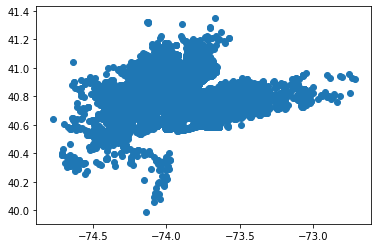

In [15]:
plt.scatter(data_tes['lon'],data_tes['lat'])

Trop de données , nous allons créer des clusters ensuite faire une regression

## Clustering

In [16]:
clusterdata = data_tes[['lat', 'lon']]

In [17]:
clusterdata.dtypes

lat    float64
lon    float64
dtype: object

In [18]:
from sklearn.cluster import KMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist 

In [19]:
Y_axis = clusterdata[['lat']]
X_axis = clusterdata[['lon']]

In [20]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(6,50) 
X = clusterdata.sample(n=10000)
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

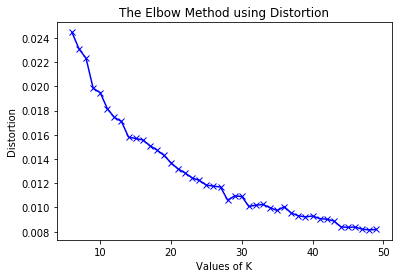

In [21]:

plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

On part alors pour 40 clusters

In [22]:
X = clusterdata
kmeans = KMeans(n_clusters=40)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

In [23]:
import seaborn as sns; sns.set()  # for plot styling

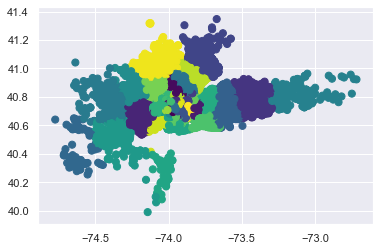

In [24]:
plt.scatter(X['lon'],X['lat'], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
#plt.plot(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

On sauvegarde le modèle pour la suite

In [25]:
import pickle

In [64]:
pickle.dump(kmeans, open('kmeansNYCUber.pickle', 'wb')) #Saving the model


In [27]:
y_kmeans

array([23,  2, 27, ...,  1, 33, 14], dtype=int32)

In [28]:
data_tes['cluster'] = y_kmeans

In [29]:
data_tes

,date/time,lat,lon,base,cluster
0,2020-02-04 00:01:00,40.2201,-74.0021,B02512,23
1,2020-02-04 00:01:00,40.7500,-74.0027,B02512,2
2,2020-02-04 00:03:00,40.7559,-73.9864,B02512,27
3,2020-02-04 00:06:00,40.7450,-73.9889,B02512,20
4,2020-02-04 00:11:00,40.8145,-73.9444,B02512,34
...,...,...,...,...,...
1028131,2020-02-04 22:57:00,40.7668,-73.9845,B02764,27
1028132,2020-02-04 22:57:00,40.6911,-74.1773,B02764,4
1028133,2020-02-04 22:58:00,40.8519,-73.9319,B02764,1
1028134,2020-02-04 22:58:00,40.7081,-74.0066,B02764,33


In [30]:
regressiondata= data_tes

In [31]:
regressiondata["date/time"] = regressiondata["date/time"].dt.time
regressiondata.rename(columns={'date/time':'time'}, inplace=True)


On a donc nos clusters. On va donc créer un modèle de régression linéaire qui va prédire le nombre de commandes en fonction de l'heure et de la position. 

In [32]:
groupbyA = regressiondata.groupby(['cluster','time'])

In [33]:
groupbyA['cluster'].count()

cluster  time    
0        00:00:00    13
         00:01:00    18
         00:02:00    14
         00:03:00    14
         00:04:00    17
                     ..
39       23:55:00     5
         23:56:00     1
         23:57:00     2
         23:58:00     2
         23:59:00     2
Name: cluster, Length: 45439, dtype: int64

On a donc un jeu de données assez interessant 

In [34]:
regressiondataset = groupbyA['cluster'].count()

In [35]:
regressiondataset = regressiondataset.to_frame(name = 'nb_pickups').reset_index()

In [36]:
regressiondataset

,cluster,time,nb_pickups
0,0,00:00:00,13
1,0,00:01:00,18
2,0,00:02:00,14
3,0,00:03:00,14
4,0,00:04:00,17
...,...,...,...
45434,39,23:55:00,5
45435,39,23:56:00,1
45436,39,23:57:00,2
45437,39,23:58:00,2


On affiche les commandes dans la zone 0

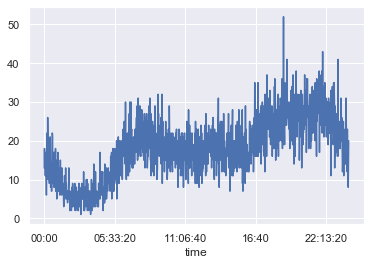

In [41]:
cluster_zero= regressiondataset[regressiondataset['cluster']==0]
plt.plot(cluster_zero['time'],cluster_zero['nb_pickups'])

In [44]:
import datetime as dt


In [49]:
def secondTime(t):
    seconds = (t.hour * 60 + t.minute) * 60 + t.second
    return seconds


In [52]:
regressiondataset['time'] = regressiondataset['time'].map(lambda x:secondTime(x))

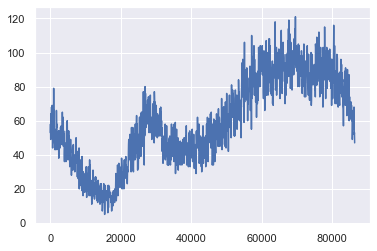

In [54]:
cluster_2= regressiondataset[regressiondataset['cluster']==2]
plt.plot(cluster_2['time'],cluster_2['nb_pickups'])

### Création du modèle !

In [55]:
#On prepare les variables pour le modèle
X = regressiondataset[['time','cluster']]
Y = regressiondataset['nb_pickups']

In [57]:
from sklearn.model_selection import train_test_split
#base d'apprentissage et base de test
from sklearn.model_selection import train_test_split
 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(40895, 2)
(4544, 2)
(40895,)
(4544,)


In [60]:
#entrainement du modèle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
 
lmodellineaire = LinearRegression()
nb_pickupsModel = lmodellineaire.fit(X_train, Y_train)

In [61]:
nb_pickupsModel

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [62]:
# Evaluation du training set
from sklearn.metrics import r2_score
y_train_predict = lmodellineaire.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)
 
print('La performance du modèle sur la base dapprentissage')
print('--------------------------------------')
print('Lerreur quadratique moyenne est {}'.format(rmse))
print('le score R2 est {}'.format(r2))
print('\n')
 
# model evaluation for testing set
y_test_predict = lmodellineaire.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)
 
print('La performance du modèle sur la base de test')
print('--------------------------------------')
print('Lerreur quadratique moyenne est {}'.format(rmse))
print('le score R2 est {}'.format(r2))

La performance du modèle sur la base dapprentissage
--------------------------------------
Lerreur quadratique moyenne est 29.814220889382568
le score R2 est 0.06712510285325135


La performance du modèle sur la base de test
--------------------------------------
Lerreur quadratique moyenne est 29.46346878826049
le score R2 est 0.07025262322080339


In [63]:
pickle.dump(nb_pickupsModel, open('nb_pickupsModel.pickle', 'wb')) #Saving the model

